In [24]:
def squad(df):
    "in batting order"
    # unique_values = df['batsman'].unique()  # Get unique values
    # appearance_order = df['batsman'].tolist()  # Get all values in order
    # unique_values_ordered_batsman = [appearance_order[i] for i, value in enumerate(unique_values) if value in appearance_order]
    seen = set()  # Create a set to store seen values
    unique_values_ordered_batsman = []
    unique_values_ordered_bowler = []
    
    for value in df['batsman']:
        if value not in seen:
            seen.add(value)
            unique_values_ordered_batsman.append(value)
    bowlers = df['bowler'].to_list()
    for i in range(len(bowlers)):
            if i%6 == 0:
                unique_values_ordered_bowler.append(bowlers[i])
    # unique_values = df['bowler'].unique()  # Get unique values
    # appearance_order = df['bowler'].tolist()  # Get all values in order
    # unique_values_ordered_bowler = [appearance_order[i] for i, value in enumerate(unique_values) if value in appearance_order]
    return unique_values_ordered_batsman, unique_values_ordered_bowler

def oppbat(x,outcome,batorder):
    opp = x.copy()
    curr1 = 0
    curr2 = 1

    
    for i in range(len(x)):
        if x[i] == batorder[curr1]:
            opp[i] = batorder[curr2]
        if x[i] == batorder[curr2]:
            opp[i] = batorder[curr1]
        # if x[i] != batorder[curr1] and x[i] != batorder[curr2]:
        #     if x[i-1] == batorder[curr1]:
        #         if (outcome[i-1] in [1,3,5]) and (i%6 !=5):
                    
        #             opp[i] = batorder[curr1]
        #         elif (outcome[i-1] in [2,4,6,7]) and (i%6 ==5):
        #             opp[i] = batorder[curr1]
        #         else:
        #             opp[i] = batorder[curr2]
        #     if x[i-1] == batorder[curr2]:
        #         if (outcome[i-1] in [1,3,5]) and (i%6 !=5):
        #             opp[i] = batorder[curr2]
        #         elif (outcome[i-1] in [2,4,6,7]) and (i%6 ==5):
        #             opp[i] = batorder[curr2]
        #         else:
        #             opp[i] = batorder[curr1]
            
        
        if outcome[i] == 7:

            if x[i] == batorder[curr1]:
                curr1 = max(curr1,curr2) + 1
            else:
                curr2 = max(curr1,curr2) + 1
    return opp


In [51]:
import pandas as pd
import numpy as np
import os, pickle
import json
data1=[]
rootdir = 'T20_matches'
cnt=0
for subdir, dirs, files in os.walk(rootdir):
    # print(dirs)
    # if(cnt>=50):
    #     break
    try: 
        for file in files:
            # print(cnt)
            if(file[-1]=='v'):
                continue
            # if(cnt>=50):
            #     break
            if file.endswith('1.pkl'):
                # print(os.path.join(subdir,"match_info.json"))
                # print(cnt)
                with open(os.path.join(subdir,file), 'rb') as f:
                    # print("here")
                    data1 = (pickle.load(f))
                    with open(os.path.join(subdir,"match_info.json")) as file:
                        match_info = json.load(file)
                        # print("here")
                    if cnt==0:
                        df1 = pd.DataFrame(data1,columns=['bowler', 'batsman', 'wickets', 'over', 'outcome'])
                        unique_values_ordered_batsman, unique_values_ordered_bowler = squad(df1)
                        df1['batting_team'] = match_info['First Innings']
                        df1['bowling_team'] = match_info['Second Innings']
                        df1['venue'] = match_info['Stadium Name']
                        df1['toss_won'] = int(match_info['Toss Winner'] == match_info['First Innings'])
                        df1['balls_bowled'] =  np.arange(1,len(df1)+1)
                        df1['batorder'] = [unique_values_ordered_batsman for _ in range(len(df1))]
                        df1['bowlers'] = [unique_values_ordered_bowler for _ in range(len(df1))]
                        df1['opposite_strike'] = oppbat(df1['batsman'].tolist(),df1['outcome'].tolist(),unique_values_ordered_batsman)
                        df1['runs'] = df1['outcome'].apply(custom_sum).cumsum() 
                        df1['runs'][1:]=df1['runs'][:-1]
                        df1['runs'][0]=0 
                        df1['match_number'] = [cnt for _ in range(len(df1))]
                        # df1['batsmanRuns'] = [{} for _ in range(len(df1))]
                        for i in range(8):
                            df1[f"{i}"] = int(0)
                        # df1['current_batsman_runs'] = [0 for _ in range(len(df1))]
                        # df1 =  df1.apply(strikeratedict,axis=1)
                        # df1 =  df1.apply(strikerate,axis=1)
                        
                        runs_dict = {}
                        stat_dict = {}
                        # Define a custom function to update the runs for the current batsman
                        def update_runs(row):
                            global runs_dict
                            batsman = row['batsman']
                            outcome = int(row['outcome'])
                            runs = runs_dict.get(batsman, 0)  # Get the current runs for the batsman (default is 0)
                            if outcome in [0,1,2,3,4,6]:  # Update runs based on the outcome
                                runs_dict[batsman] = runs + outcome
                                # print(runs1)
                            # runs_dict[batsman] = runs1  # Update runs for the batsman in the dictionary
                            return runs
                        def update_stat(row):
                            global stat_dict
                            batsman = row['batsman']
                            outcome = int(row['outcome'])
                            if batsman not in stat_dict:
                                stat_dict[batsman] = np.zeros(8)
                            
                            # stat = stat_dict.get(batsman, np.zeros(8))
                            stat = stat_dict[batsman]
                            for i in range(8):
                                row[f"{i}"] = stat[i]
                            # row[f"{outcome}"] = stat[outcome]
                            stat[outcome] = stat[outcome] + 1
                            stat_dict[batsman] = stat
                            # row[f"{outcome}"] = row[f"{outcome}"] + 1
                            return row
                        
                        df1['curr_bats_Runs'] = df1.apply(update_runs, axis=1)
                        df1 = df1.apply(update_stat, axis=1)
                        # print("df1.head()")
                    else:
                        dft = pd.DataFrame(data1,columns=['bowler', 'batsman', 'wickets', 'over', 'outcome'])
                        unique_values_ordered_batsman, unique_values_ordered_bowler = squad(dft)
                        dft['batting_team'] = match_info['First Innings']
                        dft['bowling_team'] = match_info['Second Innings']
                        dft['venue'] = match_info['Stadium Name']
                        dft['toss_won'] = int(match_info['Toss Winner'] == match_info['First Innings'])
                        dft['batorder'] = [unique_values_ordered_batsman for _ in range(len(dft))]
                        dft['bowlers'] = [unique_values_ordered_bowler for _ in range(len(dft))]
                        dft['opposite_strike'] = oppbat(dft['batsman'].tolist(),dft['outcome'].tolist(),unique_values_ordered_batsman)
                        dft['runs'] = dft['outcome'].apply(custom_sum).cumsum() 
                        dft['balls_bowled'] =  np.arange(1,len(dft)+1)
                        dft['runs'][1:]=dft['runs'][:-1]
                        dft['runs'][0]=0
                        dft['match_number'] = [cnt for _ in range(len(dft))]
                        # dft['batsmanRuns'] = [{} for _ in range(len(dft))]
                        # dft['current_batsman_runs'] = [0 for _ in range(len(dft))]
                        # dft =  dft.apply(strikeratedict,axis=1)
                        # dft =  dft.apply(strikerate,axis=1)
                        
                        runs_dict = {}

                        # Define a custom function to update the runs for the current batsman
                        def update_runs(row):
                            global runs_dict
                            batsman = row['batsman']
                            outcome = int(row['outcome'])
                            runs = runs_dict.get(batsman, 0)  # Get the current runs for the batsman (default is 0)
                            if outcome in [0,1,2,3,4,6]:  # Update runs based on the outcome
                                runs_dict[batsman] = runs + outcome
                            # runs_dict[batsman] = runs1  # Update runs for the batsman in the dictionary
                            return runs
                        def update_stat(row):
                            global stat_dict
                            batsman = row['batsman']
                            outcome = int(row['outcome'])
                            if batsman not in stat_dict:
                                stat_dict[batsman] = np.zeros(8)
                            # stat = stat_dict.get(batsman, np.zeros(8))
                            stat = stat_dict[batsman]
                            for i in range(8):
                                row[f"{i}"] = stat[i]
                            # row[f"{outcome}"] = stat[outcome]
                            stat[outcome] = stat[outcome] + 1
                            stat_dict[batsman] = stat
                            # row[f"{outcome}"] = row[f"{outcome}"] + 1
                            return row
                        dft['curr_bats_Runs'] = dft.apply(update_runs, axis=1)
                        for i in range(8):
                            dft[f"{i}"] = int(0)
                        dft = dft.apply(update_stat, axis=1)
                        df1 = pd.concat([df1,dft],ignore_index=True)



                    cnt+=1
                    
    except: 
        pass

/var/folders/lz/7tzrmr9x1xs5pplr6wnzp5jr0000gn/T/ipykernel_31456/2412490620.py:40: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df1['runs'][1:]=df1['runs'][:-1]
/var/folders/lz/7tzrmr9x1xs5pplr6wnzp5jr0000gn/T/ipykernel_31456/2412490620.py:

In [2]:
def custom_sum(x):
  """
  This function checks if the value is in the skip list and returns 0 if it is.
  Otherwise, it returns the value itself.
  """
  skip_values = [5, 7]  # Values to exclude from cumulative sum
  if x in skip_values:
    return 0
  else:
    return x

def strikeratedict(x):
  if x['batsman'] in x['batsmanRuns']:
    x['batsmanRuns'][x['batsman']]+=x['runs']
  else:
    x['batsmanRuns'][x['batsman']]=x['runs']
  return x

def strikerate(x):
  if(x['outcome'] in [5,7]):
    x['current_batsman_runs'] = x['batsmanRuns'][x['batsman']]
  else:
    x['current_batsman_runs'] = x['batsmanRuns'][x['batsman']]- x['outcome']

  return x


In [3]:
from tensorflow.keras.optimizers import Adam  # Or any other optimizer you're using


In [39]:
df1[['batsman','bowler','wickets','over','outcome','batting_team','bowling_team','venue','toss_won','balls_bowled','batorder','opposite_strike','bowlers']]

,batsman,bowler,wickets,over,outcome,batting_team,bowling_team,venue,toss_won,balls_bowled,batorder,opposite_strike,bowlers
0,Smith,Finn,0,1,1,West Indies,England,"Trent Bridge, Nottingham",1,1,"[Smith, Gayle, Simmons, Samuels, Dwayne Bravo,...",Gayle,"[Finn, Dernbach, Finn, Dernbach, Finn, Broad, ..."
1,Gayle,Finn,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,2,"[Smith, Gayle, Simmons, Samuels, Dwayne Bravo,...",Smith,"[Finn, Dernbach, Finn, Dernbach, Finn, Broad, ..."
2,Gayle,Finn,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,3,"[Smith, Gayle, Simmons, Samuels, Dwayne Bravo,...",Smith,"[Finn, Dernbach, Finn, Dernbach, Finn, Broad, ..."
3,Gayle,Finn,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,4,"[Smith, Gayle, Simmons, Samuels, Dwayne Bravo,...",Smith,"[Finn, Dernbach, Finn, Dernbach, Finn, Broad, ..."
4,Gayle,Finn,0,1,1,West Indies,England,"Trent Bridge, Nottingham",1,5,"[Smith, Gayle, Simmons, Samuels, Dwayne Bravo,...",Smith,"[Finn, Dernbach, Finn, Dernbach, Finn, Broad, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,Nasir,Arafat,4,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,116,"[Tamim, Ashraful, Shakib, Mushfiqur, Mahmudull...",Tamim,"[Hafeez, Tanvir, Umar Gul, Tanvir, Hafeez, Tan..."
20528,Shakib,Arafat,4,20,7,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,117,"[Tamim, Ashraful, Shakib, Mushfiqur, Mahmudull...",Shakib,"[Hafeez, Tanvir, Umar Gul, Tanvir, Hafeez, Tan..."
20529,Ziaur,Arafat,5,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,118,"[Tamim, Ashraful, Shakib, Mushfiqur, Mahmudull...",Tamim,"[Hafeez, Tanvir, Umar Gul, Tanvir, Hafeez, Tan..."
20530,Nasir,Arafat,5,20,4,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,119,"[Tamim, Ashraful, Shakib, Mushfiqur, Mahmudull...",Nasir,"[Hafeez, Tanvir, Umar Gul, Tanvir, Hafeez, Tan..."


In [52]:
cat_cols = ['bowler', 'batsman', 'batting_team', 'bowling_team', 'venue']
for category in cat_cols:
    df1[category] = pd.Categorical(df1[category])
    df1[category+"_idx"] = df1[category].cat.codes


batsman_dict = dict(zip(df1['batsman'].to_list(), df1['batsman_idx'].to_list()))
bowler_dict = dict(zip(df1['bowler'].to_list(), df1['bowler_idx'].to_list()))
batsman_dict


{'Smith': 268,
 'Gayle': 90,
 'Simmons': 267,
 'Samuels': 246,
 'Dwayne Bravo': 71,
 'Pollard': 215,
 'Charles': 48,
 'Sammy': 245,
 'Hyatt': 113,
 'Baugh': 25,
 'Mathurin': 162,
 'Narine': 192,
 'Edwards': 72,
 'Watson': 309,
 'Warner': 307,
 'Hussey': 112,
 'Clarke': 53,
 'White': 311,
 'Birt': 30,
 'Haddin': 95,
 'Johnson': 123,
 'Tamim': 281,
 'Rahman': 224,
 'Shakib': 257,
 'Mushfiqur': 186,
 'Nasir': 193,
 'Mahmudullah': 152,
 'Mominul': 176,
 'Sohag Gazi': 269,
 'Razzak': 233,
 'Finch': 81,
 'Marsh': 156,
 'Maxwell': 163,
 'Bailey': 21,
 'Wade': 304,
 'Faulkner': 77,
 'Amla': 9,
 'Ingram': 115,
 'Duminy': 70,
 'Miller': 172,
 'Botha': 37,
 'Kuhn': 136,
 'Peterson': 212,
 'Theron': 285,
 'Barnwell': 23,
 'Russell': 240,
 'Ramdin': 227,
 'Kamran': 125,
 'Malik': 153,
 'Imran Nazir': 114,
 'Afridi': 4,
 'Umar Akmal': 292,
 'Abdul Razzaq': 1,
 'Misbah': 174,
 'Fawad Alam': 78,
 'Tanvir': 282,
 'Amir': 8,
 'How': 111,
 'McCullum': 164,
 'Marshall': 157,
 'Taylor': 283,
 'Styris': 275

In [31]:
playas = {}
for i in df1['batting_team_idx'].unique():
    playas[i] = df1[df1['batting_team_idx']==i]['batsman_idx'].unique()
    print(i)
    print(playas[i])
    print("\n")

bowlas = {}
for i in df1['bowling_team_idx'].unique():
    bowlas[i] = df1[df1['bowling_team_idx']==i]['bowler_idx'].unique()
    print(i)
    print(bowlas[i])
    print("\n")

8
[268  90 267 246  71 215  48 245 113  25 162 192  72  23 240 227  61 249
  46  64 283 172  28  24  19 229  83 201  69 180 107  34 235  52  31]


0
[309 307 112  53 311  30  95 123 268  81 156 163  21 304  77 101 166  52
  58 206 202  92 103 217 278 108 141  39 191 280 303 237 147 105  55 109
  79 199 102 106 264 158 129]


1
[281 224 257 186 193 152 176 269 233 263  14 170 230 171 196 239   5 190
 179 277 255 253 195 126  75 321]


6
[268   9 115  70 172  37 136 212 285  36 325 211 168  91 203 178 134 144
 130 116 284 104 139 124  38 216 221 200 197 299 167  62 324 326 312 207
 142  26 327 272 213]


5
[125 153 114   4 292   1 174  78 282   8 256 175  96  17 252 259 118 293
 155  12 228 317   7 244 318  13 260  76 322 294   2 194 305 100  98  18
 131 261 248]


4
[111 164 157 283 275  88  85 300 173 161  94  87 242 165  82  16   3  33
  93 204 287 270 302 169 198 314 323  42  43 110 241  65 140 184 237  73
 208 308]


2
[ 35 315 214 254 205   0  86 132 177  22  44 208  41 145  40 316

In [53]:
def padbatorder(x):
    news = []
    for i in range(len(x['batorder'])):
        news.append(batsman_dict[x['batorder'][i]])
    if len(news)<11:
        for i in range(11-len(news)):
            a = np.random.choice(playas[x['batting_team_idx']])
            while a in news:
                a = np.random.choice(playas[x['batting_team_idx']])
                
            news.append(a)
    x['batorder'] = news
    return x

def padbowlorder(x):
    news = []
    for i in range(len(x['bowlers'])):
        news.append(bowler_dict[x['bowlers'][i]])
    if len(news)<20:
        for i in range(20-len(news)):
            a = np.random.choice(bowlas[x['bowling_team_idx']])
            while a in news:
                a = np.random.choice(bowlas[x['bowling_team_idx']])
                
            news.append(a)
    x['bowlers'] = news
    return x


In [54]:
df1.columns

Index(['bowler', 'batsman', 'wickets', 'over', 'outcome', 'batting_team',
       'bowling_team', 'venue', 'toss_won', 'balls_bowled', 'batorder',
       'bowlers', 'opposite_strike', 'runs', 'match_number', '0', '1', '2',
       '3', '4', '5', '6', '7', 'curr_bats_Runs', 'bowler_idx', 'batsman_idx',
       'batting_team_idx', 'bowling_team_idx', 'venue_idx'],
      dtype='object')

In [55]:
df1 = df1.apply(padbatorder,axis=1)
df1 = df1.apply(padbowlorder,axis=1)

In [56]:
df1[['batsman','bowler','wickets','over','outcome','batting_team','bowling_team','venue','toss_won','balls_bowled','batorder','opposite_strike','bowlers']]

,batsman,bowler,wickets,over,outcome,batting_team,bowling_team,venue,toss_won,balls_bowled,batorder,opposite_strike,bowlers
0,Smith,Finn,0,1,1,West Indies,England,"Trent Bridge, Nottingham",1,1,"[268, 90, 267, 246, 71, 215, 235, 227, 83, 201...",Gayle,"[77, 58, 77, 58, 77, 38, 209, 160, 209, 160, 2..."
1,Gayle,Finn,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,2,"[268, 90, 267, 246, 71, 215, 240, 64, 245, 72,...",Smith,"[77, 58, 77, 58, 77, 38, 209, 160, 209, 160, 2..."
2,Gayle,Finn,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,3,"[268, 90, 267, 246, 71, 215, 34, 227, 19, 83, ...",Smith,"[77, 58, 77, 58, 77, 38, 209, 160, 209, 160, 2..."
3,Gayle,Finn,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,4,"[268, 90, 267, 246, 71, 215, 19, 83, 162, 245,...",Smith,"[77, 58, 77, 58, 77, 38, 209, 160, 209, 160, 2..."
4,Gayle,Finn,0,1,1,West Indies,England,"Trent Bridge, Nottingham",1,5,"[268, 90, 267, 246, 71, 215, 52, 19, 192, 229,...",Smith,"[77, 58, 77, 58, 77, 38, 209, 160, 209, 160, 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,Nasir,Arafat,4,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,116,"[281, 14, 257, 186, 152, 193, 321, 5, 239, 253...",Tamim,"[81, 215, 227, 215, 81, 215, 5, 81, 5, 7, 227,..."
20528,Shakib,Arafat,4,20,7,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,117,"[281, 14, 257, 186, 152, 193, 321, 233, 195, 5...",Shakib,"[81, 215, 227, 215, 81, 215, 5, 81, 5, 7, 227,..."
20529,Ziaur,Arafat,5,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,118,"[281, 14, 257, 186, 152, 193, 321, 190, 224, 5...",Tamim,"[81, 215, 227, 215, 81, 215, 5, 81, 5, 7, 227,..."
20530,Nasir,Arafat,5,20,4,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,119,"[281, 14, 257, 186, 152, 193, 321, 263, 277, 1...",Nasir,"[81, 215, 227, 215, 81, 215, 5, 81, 5, 7, 227,..."


In [86]:
def opstriker(x):
    return batsman_dict[x]
df1["opposite_strike"] = df1["opposite_strike"].apply(opstriker)

In [87]:
# df2 = df1[['bowler_idx', 'batsman_idx', 'wickets', 'over', 'batting_team_idx', 'bowling_team_idx', 'venue_idx', 'toss_won','balls_bowled','runs','curr_bats_Runs','0','1','2','3','4','5','6','7' , 'outcome']]
df2 = df1[['bowler_idx', 'batsman_idx', 'wickets', 'over', 'batting_team_idx', 'bowling_team_idx', 'venue_idx', 'toss_won','balls_bowled','runs','opposite_strike','outcome']]


Deciding match to test on

In [88]:
df_test = df1[df1['match_number']==171]

In [89]:
df_test2 = df_test[['bowler_idx', 'batsman_idx', 'wickets', 'over', 'batting_team_idx', 'bowling_team_idx', 'venue_idx', 'toss_won','balls_bowled','runs' ,'opposite_strike', 'outcome']]

Creating sequences

In [66]:
def create_sequences(df, max_len):
  """
  This function extracts sequences of a fixed length from a Pandas DataFrame 
  containing cricket match data and creates sequences with arrays of features.

  Args:
      df: A Pandas DataFrame containing cricket match data (e.g., batsman, bowler, outcome for each ball).
      max_len: The desired length of each sequence (number of balls).

  Returns:
      A numpy array of shape (num_sequences, max_len, features) containing sequences.
  """

  sequences = []
  for i in range(df.shape[0] - max_len + 1):  # Slide window approach
    sequence = []
    for j in range(i, i + max_len):
      # Access data for each ball using row indexing
      ball_data = df.iloc[j]
      # Create a numpy array of features for this ball
      features = np.array([ball_data[col] for col in df.columns if col not in ['index','bowler', 'batsman', 'batting_team', 'bowling_team', 'venue']])  # Exclude index column
      sequence.append(features)  # Append array of features to sequence
    sequences.append(sequence)

  # Convert sequences to numpy array (no reshape needed here)
  sequences = np.array(sequences)
  return sequences
def get_target_variable(sequence):
  """
  This function retrieves the target variable (outcome of the next ball) 
  corresponding to a sequence of balls.

  Args:
      sequence: A list representing a sequence of balls (features for each ball).

  Returns:
      The target variable (outcome of the next ball) encoded as needed.
  """
  # Assuming the outcome is the last element in the sequence (modify as needed)
  target_variable = sequence[-1][-1]
  # Encode the target variable (e.g., one-hot encoding for multi-class classification)
  # ... (your target variable encoding logic) ...
  return target_variable

In [67]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

# Define parameters (replace with your values)
max_len = 12  # Maximum sequence length (number of balls)
num_features = 8  # Total number of features after encoding (replace with actual number)


In [90]:
sequences = create_sequences(df2, max_len)
target_variables = []
for sequence in sequences:  # Function to create sequences of length max_len
    target_variables.append(get_target_variable(sequence)) 

In [91]:
test_sequences = create_sequences(df_test2, max_len)
target_variables_test = []
for sequence in test_sequences:  # Function to create sequences of length max_len
    target_variables_test.append(get_target_variable(sequence)) 

In [19]:
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', value=-1)
padded_sequences

array([[[ 81, 296,   0, ...,   1,   1,   1],
        [ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        ...,
        [ 62, 296,   0, ...,   1,   3,   0],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1]],

       [[ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        ...,
        [ 62, 296,   0, ...,   1,   7,   4],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1]],

       [[ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   2,   1],
        ...,
        [ 62, 296,   0, ...,   1,   7,   0],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1]],

       ...,

       [[  8, 216,   4, ...,   1, 147,   1],
        [  8, 285,   4, ...,   1, 149,   2],
        [  8, 285,   4, ...,   1, 152,   3

In [92]:
X_train = []
y_train = []
outcome_index = -1  # Assuming outcome is the last element in each sequence
for sequence in sequences:
    # Extract features (excluding outcome)
    # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
    # X_train.append(sequence[:-1][:,:-1])
    X_train.append(sequence[:,:-1])
    
    # Extract target variable (outcome)
    target = sequence[-1][outcome_index]
    y_train.append(target)


In [93]:
X_sim = []
y_sim = []
outcome_index = -1  # Assuming outcome is the last element in each sequence
for sequence in test_sequences:
    # Extract features (excluding outcome)
    # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
    # X_train.append(sequence[:-1][:,:-1])
    X_sim.append(sequence[:,:-1])
    
    # Extract target variable (outcome)
    target = sequence[-1][outcome_index]
    y_sim.append(target)


In [94]:
sequence[:,:-1].shape

(12, 11)

In [95]:
X_train = np.array(X_train)
X_train.shape

(20521, 12, 11)

In [96]:
y_train = np.array(y_train)
y_train.shape

(20521,)

In [97]:
X_sim = np.array(X_sim)
print(X_sim.shape)
y_sim = np.array(y_sim)
print(y_sim.shape)

(109, 12, 11)
(109,)


In [98]:
n_train_time = int(0.8 * X_train.shape[0])
X_train ,X_test = X_train[:n_train_time], X_train[n_train_time:]
print(X_train.shape, X_test.shape)
y_train, y_test = y_train[:n_train_time], y_train[n_train_time:]
print(y_train.shape, y_test.shape)

(16416, 12, 11) (4105, 12, 11)
(16416,) (4105,)


In [99]:
y_train1= (pd.get_dummies(pd.DataFrame(y_train, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values)

In [100]:
y_test1= (pd.get_dummies(pd.DataFrame(y_test, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values) 

In [101]:
y_sim1= (pd.get_dummies(pd.DataFrame(y_sim, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values)

In [102]:
y_train1.shape

(16416, 8)

In [81]:
from keras.layers import Dropout
import matplotlib.pyplot as plt

In [231]:
pd.DataFrame(y_train).value_counts()

0  
1.0    9375
0.0    7376
4.0    2537
2.0    1899
7.0    1330
6.0    1026
3.0     149
5.0       5
Name: count, dtype: int64

In [82]:
from tensorflow.keras.callbacks import EarlyStopping

Epoch 1/100


/Users/rahul/miniconda3/envs/btp/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


513/513 - 5s - 9ms/step - accuracy: 0.3995 - loss: 1.5254 - val_accuracy: 0.4114 - val_loss: 1.4751
Epoch 2/100
513/513 - 3s - 6ms/step - accuracy: 0.4218 - loss: 1.4923 - val_accuracy: 0.4307 - val_loss: 1.4700
Epoch 3/100
513/513 - 3s - 6ms/step - accuracy: 0.4321 - loss: 1.4868 - val_accuracy: 0.4290 - val_loss: 1.4686
Epoch 4/100
513/513 - 3s - 6ms/step - accuracy: 0.4345 - loss: 1.4840 - val_accuracy: 0.4314 - val_loss: 1.4681
Epoch 5/100
513/513 - 3s - 6ms/step - accuracy: 0.4366 - loss: 1.4812 - val_accuracy: 0.4382 - val_loss: 1.4650
Epoch 6/100
513/513 - 3s - 6ms/step - accuracy: 0.4380 - loss: 1.4799 - val_accuracy: 0.4380 - val_loss: 1.4655
Epoch 7/100
513/513 - 3s - 6ms/step - accuracy: 0.4393 - loss: 1.4769 - val_accuracy: 0.4373 - val_loss: 1.4638
Epoch 8/100
513/513 - 3s - 6ms/step - accuracy: 0.4394 - loss: 1.4755 - val_accuracy: 0.4375 - val_loss: 1.4623
Epoch 9/100
513/513 - 3s - 6ms/step - accuracy: 0.4376 - loss: 1.4740 - val_accuracy: 0.4361 - val_loss: 1.4617
Epoc

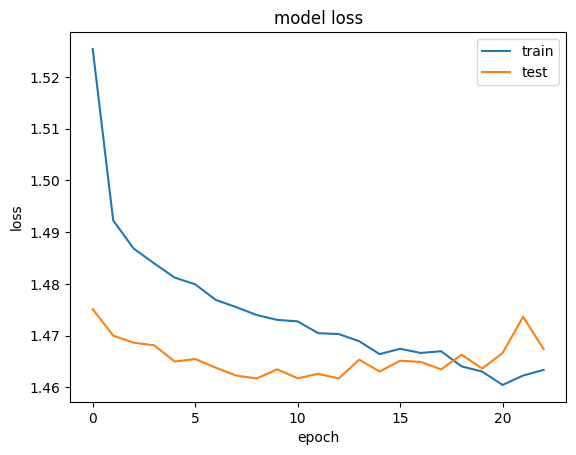

In [103]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))

#    model.add(LSTM(70))
#    model.add(Dropout(0.3))


model.add(LSTM(units=64))
model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(8, activation='softmax'))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train1, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test1), verbose=2, shuffle=False,
                    callbacks=[early_stopping])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# # fit network
# history = model.fit(X_train, y_train1, epochs=100, batch_size=32, validation_data=(X_test, y_test1), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [38]:
def permute_importance(x,y,model,feature):
    """
    This function calculates the permutation importance of a feature in a model.
    
    Args:
        x: A numpy array containing the input features.
        y: A numpy array containing the target variable.
        model: A trained machine learning model.
        feature: The feature for which to calculate the permutation importance.
        
    Returns:
        The permutation importance of the feature.
    """
    baseline = model.evaluate(x, y, verbose=0)[1]  # Baseline accuracy
    x_copy = x.copy()  # Create a copy of the input features
    shuffle_column = x_copy[:, feature]  # Extract the feature to be permuted
    x_copy[:, feature] = np.random.permutation(shuffle_column)  # Permuted feature
    permuted_score = model.evaluate(x_copy, y, verbose=0)[1]  # Score with permuted feature
    return baseline - permuted_score  # Permutation importance
    

In [266]:
colss = df2.columns.to_list()

In [267]:
f1 = permute_importance(X_test, y_test1,model,3)

print(f1)
for i in range(0,9):
    print(f"{colss[i]} : {permute_importance(X_test, y_test1,model,i)}")

0.0018565356731414795
bowler_idx : 0.00270041823387146
batsman_idx : 0.0030379891395568848
wickets : 0.0003375411033630371
over : 0.002025306224822998
batting_team_idx : 0.0015189945697784424
bowling_team_idx : 0.004388183355331421
venue_idx : 0.0018565356731414795
toss_won : 0.0005063414573669434
balls_bowled : 0.0018565356731414795


In [92]:
t = np.argmax(model.predict(X_train), axis=1)

741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [93]:
t[t==7].shape

(0,)

In [60]:
df3 = df1.iloc[-120:-1]

In [61]:
df3

,bowler,batsman,wickets,over,outcome,batting_team,bowling_team,venue,toss_won,runs,bowler_idx,batsman_idx,batting_team_idx,bowling_team_idx,venue_idx
29513,Hafeez,Tamim,0,1,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,1,86,310,1,5,33
29514,Hafeez,Ashraful,0,1,0,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,1,86,15,1,5,33
29515,Hafeez,Ashraful,0,1,0,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,1,86,15,1,5,33
29516,Hafeez,Ashraful,0,1,4,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,5,86,15,1,5,33
29517,Hafeez,Ashraful,0,1,2,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,7,86,15,1,5,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29627,Arafat,Shakib,4,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,159,14,285,1,5,33
29628,Arafat,Nasir,4,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,160,14,216,1,5,33
29629,Arafat,Shakib,4,20,7,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,160,14,285,1,5,33
29630,Arafat,Ziaur,5,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,161,14,356,1,5,33


In [62]:
df4 = df3[['bowler_idx', 'batsman_idx', 'wickets', 'over', 'batting_team_idx', 'bowling_team_idx', 'venue_idx', 'toss_won','runs', 'outcome']]

In [63]:
sequences = create_sequences(df4, max_len)
target_variables = []
for sequence in sequences:  # Function to create sequences of length max_len
    target_variables.append(get_target_variable(sequence)) 
X_test3 = []
y_test3 = []
outcome_index = -1  # Assuming outcome is the last element in each sequence
for sequence in sequences:
    # Extract features (excluding outcome)
    # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
    # X_train.append(sequence[:-1][:,:-1])
    X_test3.append(sequence[:,:-1])
    
    # Extract target variable (outcome)
    target = sequence[-1][outcome_index]
    y_test3.append(target)
X_test3 = np.array(X_test3)
y_test3 = np.array(y_test3)





In [64]:
y_preds3 = model.predict(X_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


In [68]:
max_indices = np.argmax(y_preds3, axis=1)

In [80]:
max_indices

array([0, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0, 0, 0, 2, 0, 4, 4, 1, 1, 1, 1, 0,
       4, 4, 4, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 6, 0, 1, 0, 0, 0, 4, 0, 1,
       0, 1, 1, 0, 2, 4, 4, 0, 1, 6, 4, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 4,
       6, 1, 0, 1, 0, 4, 1, 1, 1, 1, 0, 1, 0, 4, 0, 0, 0, 1, 1, 0, 1, 0,
       2, 1, 1, 1, 1, 4, 0, 0, 2, 4, 4, 0, 2, 4, 1, 1, 4, 1, 1, 0, 1, 4])

In [70]:
test_runs = df3['outcome'].values

In [72]:
test_runs[test_runs ==  7] = 0

In [78]:
test_runs

array([1, 0, 0, 4, 2, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0, 0, 0,
       2, 0, 4, 4, 1, 1, 1, 1, 0, 4, 4, 4, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2,
       6, 0, 1, 0, 0, 0, 3, 0, 1, 0, 1, 1, 0, 2, 4, 4, 0, 1, 6, 4, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 4, 6, 1, 0, 1, 0, 4, 1, 1, 1, 1, 0, 1, 0,
       4, 0, 0, 0, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 4, 0, 0, 2, 4, 4, 1, 2,
       3, 1, 1, 4, 1, 1, 0, 1, 4])

In [77]:
np.cumsum(test_runs)

array([  1,   1,   1,   5,   7,   7,  11,  11,  11,  11,  11,  11,  11,
        15,  15,  15,  19,  23,  27,  27,  27,  27,  29,  29,  33,  37,
        38,  39,  40,  41,  41,  45,  49,  53,  53,  53,  53,  54,  55,
        56,  56,  56,  56,  58,  64,  64,  65,  65,  65,  65,  68,  68,
        69,  69,  70,  71,  71,  73,  77,  81,  81,  82,  88,  92,  93,
        93,  93,  94,  95,  96,  97,  97,  98,  98, 102, 108, 109, 109,
       110, 110, 114, 115, 116, 117, 118, 118, 119, 119, 123, 123, 123,
       123, 124, 125, 125, 126, 126, 128, 129, 130, 131, 132, 136, 136,
       136, 138, 142, 146, 147, 149, 152, 153, 154, 158, 159, 160, 160,
       161, 165])

In [82]:
predsum=np.zeros(110)
for i in range(110):
    predsum[i] = np.cumsum(test_runs)[i+9]+max_indices[i]


In [83]:
predsum

array([ 11.,  11.,  11.,  11.,  19.,  15.,  15.,  23.,  27.,  31.,  27.,
        27.,  27.,  31.,  29.,  37.,  41.,  39.,  40.,  41.,  42.,  41.,
        49.,  53.,  57.,  53.,  53.,  53.,  55.,  56.,  57.,  56.,  56.,
        56.,  60.,  70.,  64.,  66.,  65.,  65.,  65.,  72.,  68.,  70.,
        69.,  71.,  72.,  71.,  75.,  81.,  85.,  81.,  83.,  94.,  96.,
        94.,  93.,  93.,  95.,  96.,  97.,  98.,  97.,  99.,  98., 106.,
       114., 110., 109., 111., 110., 118., 116., 117., 118., 119., 118.,
       120., 119., 127., 123., 123., 123., 125., 126., 125., 127., 126.,
       130., 130., 131., 132., 133., 140., 136., 136., 140., 146., 150.,
       147., 151., 156., 154., 155., 162., 160., 161., 160., 162., 169.])

In [84]:
predsum.shape

(110,)

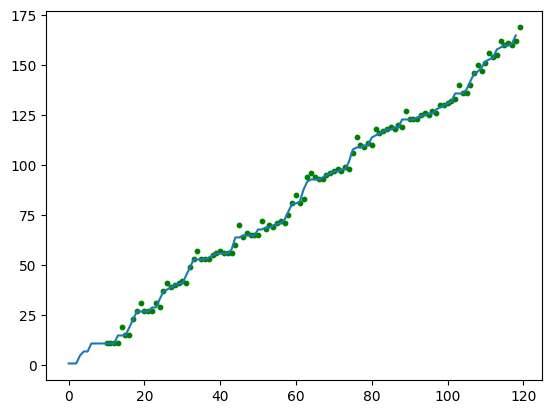

In [87]:
additional_x_values = np.arange(10, 120)

plt.plot(np.cumsum(test_runs))
plt.scatter(additional_x_values, predsum, s=10,c='g')

plt.show()

In [257]:
sequences[0][-1]

array([ 62., 296.,   0.,   2.,   8.,   2.,  53.,   1.,  12.,   7.,   5.,
         3.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.])

In [104]:
df2.columns

Index(['bowler_idx', 'batsman_idx', 'wickets', 'over', 'batting_team_idx',
       'bowling_team_idx', 'venue_idx', 'toss_won', 'balls_bowled', 'runs',
       'opposite_strike', 'outcome'],
      dtype='object')

In [153]:
stat_dict1 = {}
def new_inp(x, out,df):
    """
    This function creates a new input sequence by adding the outcome of the next ball to the end of the input sequence.
    
    Args:
        x: A numpy array containing the input features.
        out: The outcome of the next ball.
        
    Returns:
        A new numpy array containing the input features with the outcome of the next ball added.
    """
    new_x = x.copy()  # Create a copy of the input features
    las_ball = new_x[-1]
    new_last_ball = las_ball.copy()
    btord = df['batorder'].iloc[0]
    btord.append(0)
    bowlers = df['bowlers'].iloc[0]
    bowlers.append(0)
    curr1 = np.where(btord == las_ball[np.where(df2.columns == 'batsman_idx')[0][0]])[0][0]
    curr2 = np.where(btord == las_ball[np.where(df2.columns == 'opposite_strike')[0][0]])[0][0]
    #update balls
    new_last_ball[np.where(df2.columns == 'balls_bowled')[0][0]]+=1
    
    if out == 7:
        new_last_ball[np.where(df2.columns == 'wickets')[0][0]]+=1

        if las_ball[np.where(df2.columns == 'batsman_idx')[0][0]] == btord[curr1]:
            # stat_dict1[btord[curr1]][7] += 1 
            curr1 = max(curr1,curr2) + 1
            new_last_ball[np.where(df2.columns == 'batsman_idx')[0][0]] = btord[curr1]
            # runs_dict[btord[curr1]] = 0

            
        else:
            curr2 = max(curr1,curr2) + 1
            new_last_ball[np.where(df2.columns == 'batsman_idx')[0][0]] = btord[curr2]

    elif out in [1,3,5]:
        new_last_ball[np.where(df2.columns == 'runs')[0][0]]+=out
        if las_ball[np.where(df2.columns == 'batsman_idx')[0][0]] == btord[curr1]:
            new_last_ball[np.where(df2.columns == 'batsman_idx')[0][0]] = btord[curr2]     
            new_last_ball[np.where(df2.columns == 'opposite_strike')[0][0]] = btord[curr1]     
                  
        else:
            new_last_ball[np.where(df2.columns == 'batsman_idx')[0][0]] = btord[curr1]
            new_last_ball[np.where(df2.columns == 'opposite_strike')[0][0]] = btord[curr2]

    else:
        new_last_ball[np.where(df2.columns == 'runs')[0][0]]+=out
    
    if las_ball[np.where(df2.columns == 'balls_bowled')[0][0]] % 6  == 0:
        new_last_ball[np.where(df2.columns == 'over')[0][0]] += 1
        new_last_ball[np.where(df2.columns == 'bowler_idx')[0][0]] = bowlers[new_last_ball[np.where(df2.columns == 'over')[0][0]]-1]
        if new_last_ball[np.where(df2.columns == 'batsman_idx')[0][0]] == btord[curr1]:
            new_last_ball[np.where(df2.columns == 'batsman_idx')[0][0]] = btord[curr2]     
            new_last_ball[np.where(df2.columns == 'opposite_strike')[0][0]] = btord[curr1]     
                  
        else:
            new_last_ball[np.where(df2.columns == 'batsman_idx')[0][0]] = btord[curr1]
            new_last_ball[np.where(df2.columns == 'opposite_strike')[0][0]] = btord[curr2]

    new_x = np.vstack([new_x, new_last_ball])  # Add the outcome of the next ball to the end of the input sequence
    
    return new_x[1:] # Return the new input sequence with the first element removed


In [105]:
y_sim

array([2, 0, 0, 1, 0, 0, 4, 0, 1, 7, 2, 0, 0, 4, 1, 0, 0, 7, 0, 0, 6, 7,
       0, 0, 0, 1, 0, 1, 1, 6, 0, 0, 1, 0, 6, 1, 0, 1, 1, 4, 1, 0, 1, 0,
       4, 1, 1, 1, 7, 1, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0, 4, 1, 2, 4, 1, 1,
       0, 4, 1, 2, 0, 4, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 7, 4, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 2, 4, 4, 2, 4, 2, 2, 0, 1, 1, 1, 4, 1, 7])

In [106]:
test_sequences

array([[[207,  89,   0, ...,   0, 251,   4],
        [207,  89,   0, ...,   4, 251,   0],
        [207,  89,   0, ...,   4, 251,   0],
        ...,
        [136, 251,   0, ...,  14,  89,   1],
        [136,  89,   0, ...,  15, 251,   0],
        [136,  89,   0, ...,  15, 251,   2]],

       [[207,  89,   0, ...,   4, 251,   0],
        [207,  89,   0, ...,   4, 251,   0],
        [207,  89,   0, ...,   4, 251,   4],
        ...,
        [136,  89,   0, ...,  15, 251,   0],
        [136,  89,   0, ...,  15, 251,   2],
        [207, 251,   0, ...,  17,  89,   0]],

       [[207,  89,   0, ...,   4, 251,   0],
        [207,  89,   0, ...,   4, 251,   4],
        [207,  89,   0, ...,   8, 251,   1],
        ...,
        [136,  89,   0, ...,  15, 251,   2],
        [207, 251,   0, ...,  17,  89,   0],
        [207, 251,   0, ...,  17,  89,   0]],

       ...,

       [[102, 225,   5, ..., 121,  66,   2],
        [102, 225,   5, ..., 123,  66,   4],
        [207,  66,   5, ..., 127, 225,   4

In [114]:
model.predict(X_sim[1:2])[0].argmax()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


0

In [183]:
def simulate(simulatefrom,X_sim):
    outs = []
    outs1 =[]
    outssum= []
    in1 = X_sim[simulatefrom:simulatefrom+1]
    out1 = model.predict(in1)
    out1_ = np.array([out1[0][0]/p1[0], out1[0][1]/p1[1], out1[0][2]/p1[2], out1[0][3]/p1[3], out1[0][4]/p1[4], out1[0][5]/p1[5], out1[0][6]/p1[6], out1[0][7]/p1[7]])
    outs.append(out1[0].argmax())
    outs1.append(out1_.argmax())
    outssum.append(out1[0][1]+2*out1[0][2]+3*out1[0][3]+4*out1[0][4]+6*out1[0][6])
    in2 = new_inp(in1[0],out1[0].argmax(),df_test).reshape(1,12,11)
    while in2[0][-1][np.where(df2.columns == 'balls_bowled')[0][0]]<=120 and in2[0][-1][np.where(df2.columns == 'wickets')[0][0]]<10:
        out2 = model.predict(in2)
        in2 = new_inp(in2[0],out2[0].argmax(),df_test).reshape(1,12,11)
        outs.append(out2[0].argmax())
        out2_ = np.array([out2[0][0]/p1[0], out2[0][1]/p1[1], out2[0][2]/p1[2], out2[0][3]/p1[3], out2[0][4]/p1[4], out2[0][5]/p1[5], out2[0][6]/p1[6], out2[0][7]/p1[7]])
    
        outs1.append(out2_[0].argmax())

        outssum.append(out2[0][1]+2*out2[0][2]+3*out2[0][3]+4*out2[0][4]+6*out2[0][6])
        print(in2[0][-1])
    print(outssum)
    return outs,outs1

In [123]:
df_test['batorder'].iloc[0]

[89, 251, 135, 236, 319, 225, 66, 258, 219, 301, 99]

In [135]:
X_sim[1:2][0].reshape(1,12,11)

array([[[207,  89,   0,   1,   3,   6,  36,   0,   2,   4, 251],
        [207,  89,   0,   1,   3,   6,  36,   0,   3,   4, 251],
        [207,  89,   0,   1,   3,   6,  36,   0,   4,   4, 251],
        [207,  89,   0,   1,   3,   6,  36,   0,   5,   8, 251],
        [207, 251,   0,   1,   3,   6,  36,   0,   6,   9,  89],
        [136,  89,   0,   2,   3,   6,  36,   0,   7,   9, 251],
        [136, 251,   0,   2,   3,   6,  36,   0,   8,  10,  89],
        [136, 251,   0,   2,   3,   6,  36,   0,   9,  12,  89],
        [136, 251,   0,   2,   3,   6,  36,   0,  10,  14,  89],
        [136,  89,   0,   2,   3,   6,  36,   0,  11,  15, 251],
        [136,  89,   0,   2,   3,   6,  36,   0,  12,  15, 251],
        [207, 251,   0,   3,   3,   6,  36,   0,  13,  17,  89]]])

In [143]:
df2.columns

Index(['bowler_idx', 'batsman_idx', 'wickets', 'over', 'batting_team_idx',
       'bowling_team_idx', 'venue_idx', 'toss_won', 'balls_bowled', 'runs',
       'opposite_strike', 'outcome'],
      dtype='object')

In [184]:
outs,outs1 = simulate(1,X_sim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[207 251   0   3   3   6  36   0  15  17  89]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[207 251   0   3   3   6  36   0  16  17  89]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[207 251   0   3   3   6  36   0  17  17  89]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[207  89   0   3   3   6  36   0  18  18 251]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[136 251   0   4   3   6  36   0  19  18  89]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[136 251   0   4   3   6  36   0  20  18  89]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[136 251   0   4   3   6  36   0  21  18  89]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[136 251   0   4   3   6  36   0  22  18  89]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[136 251   0   4   3   6  36   0  23  18  89]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[136 251   0   4   3   6  36   0  24  18  89]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[102  89   0   5   3   6  36   0  25  18 251]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [185]:
outs1

[4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [167]:
np.array(outs).cumsum()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [164]:
outs1

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 2,
 4,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [163]:
np.array(outs1).cumsum()

array([  4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,  52,
        56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100, 104,
       108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156,
       160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208,
       212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260,
       262, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 302, 306,
       308, 312, 314, 316, 318, 320, 324, 326, 328, 330, 332, 334, 336,
       338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362,
       364, 366, 368, 370])

In [173]:
p1 = (df1['outcome'].value_counts()/df1.shape[0]).to_dict()

In [178]:
p1

{1: 0.39401909214884084,
 0: 0.31492304695110074,
 4: 0.10865965322423533,
 2: 0.07953438534969803,
 7: 0.05430547438145334,
 6: 0.04149620105201637,
 3: 0.0067212156633547635,
 5: 0.00034093122930060394}

In [126]:
np.where(df2.columns == 'batsman_idx')[0][0]

1

In [86]:
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

In [185]:
df_team1 = df2[df2['batting_team_idx'] == 0]
sequences = create_sequences(df_team1, 10)
target_variables = []
for sequence in sequences:  # Function to create sequences of length max_len
    target_variables.append(get_target_variable(sequence)) 

padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', value=-1)
padded_sequences
X_train = []
y_train = []
outcome_index = -1  # Assuming outcome is the last element in each sequence
for sequence in sequences:
    # Extract features (excluding outcome)
    # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
    # X_train.append(sequence[:-1][:,:-1])
    X_train.append(sequence[:,:-1])
    
    # Extract target variable (outcome)
    target = sequence[-1][outcome_index]
    y_train.append(target)
X_train = np.array(X_train)
y_train = np.array(y_train)
n_train_time = int(0.8 * X_train.shape[0])
X_train ,X_test = X_train[:n_train_time], X_train[n_train_time:]
print(X_train.shape, X_test.shape)
y_train, y_test = y_train[:n_train_time], y_train[n_train_time:]
y_train1= (pd.get_dummies(pd.DataFrame(y_train, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values)
y_test1= (pd.get_dummies(pd.DataFrame(y_test, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values) 



(3111, 10, 9) (778, 10, 9)


Epoch 1/100


/Users/rahul/miniconda3/envs/btp/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


389/389 - 4s - 10ms/step - accuracy: 0.3815 - loss: 1.5960 - val_accuracy: 0.4023 - val_loss: 1.5408
Epoch 2/100
389/389 - 2s - 5ms/step - accuracy: 0.4008 - loss: 1.5494 - val_accuracy: 0.4139 - val_loss: 1.5313
Epoch 3/100
389/389 - 2s - 5ms/step - accuracy: 0.4079 - loss: 1.5389 - val_accuracy: 0.4010 - val_loss: 1.5263
Epoch 4/100
389/389 - 2s - 5ms/step - accuracy: 0.4188 - loss: 1.5298 - val_accuracy: 0.3997 - val_loss: 1.5348
Epoch 5/100
389/389 - 2s - 5ms/step - accuracy: 0.4131 - loss: 1.5232 - val_accuracy: 0.4075 - val_loss: 1.5327
Epoch 6/100
389/389 - 2s - 5ms/step - accuracy: 0.4221 - loss: 1.5207 - val_accuracy: 0.4126 - val_loss: 1.5226
Epoch 7/100
389/389 - 2s - 5ms/step - accuracy: 0.4201 - loss: 1.5186 - val_accuracy: 0.3985 - val_loss: 1.5229
Epoch 8/100
389/389 - 2s - 5ms/step - accuracy: 0.4262 - loss: 1.5154 - val_accuracy: 0.4126 - val_loss: 1.5273
Epoch 9/100
389/389 - 2s - 5ms/step - accuracy: 0.4198 - loss: 1.5093 - val_accuracy: 0.4036 - val_loss: 1.5280
Epo

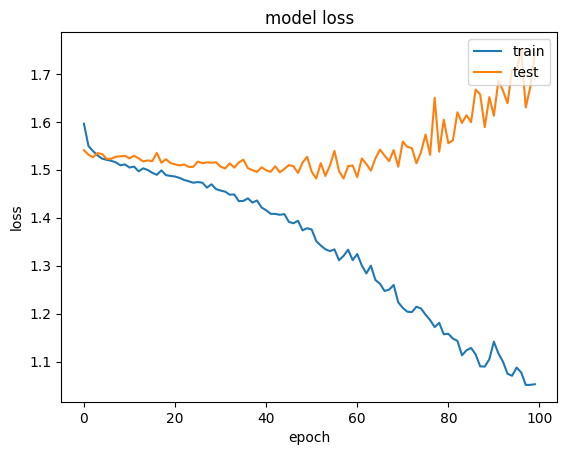

In [186]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))

#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
# model.add(LSTM(units=32))
# model.add(Dropout(0.2))

# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(7, activation='softmax'))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
optimizer = Adam(learning_rate=0.01)  # Replace 0.001 with your desired learning rate

# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit network
history = model.fit(X_train, y_train1, epochs=100, batch_size=8, validation_data=(X_test, y_test1), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [ ]:
#DROP OUTCOME =5 remember important